# 0.  Mô tả

## Seq2Seq Transformer for Vietnamese–English Machine Translation (PhoMT)

- Dataset: **PhoMT** (folder `data-mt/PhoMT/detokenization`)
- Mô hình: **Transformer Encoder–Decoder from scratch** (Attention, FFN, LayerNorm, Positional Encoding)
- Nhiệm vụ: Dịch máy **Vi → En**, huấn luyện trên PhoMT, đánh giá bằng **BLEU** và chuẩn bị file cho **Gemini Score**.

---

## Mục lục

1. [Thiết lập môi trường & cấu hình](#setup)
2. [Giới thiệu & tải dữ liệu PhoMT](#data)
3. [Tiền xử lý & Thám phá dữ liệu (EDA)](#eda)
4. [Xây dựng Vocabulary & phân tích coverage](#vocab)
5. [Dataset, DataLoader](#dataloader)
6. [Kiến trúc Transformer từ đầu](#model)
7. [Huấn luyện mô hình](#training)
8. [Đánh giá: Loss, Perplexity, BLEU](#evaluation)
9. [Xuất kết quả & Gemini Score](#gemini)


# 1. Thiết lập môi trường & cấu hình

In [1]:
# ==== Cell 1: Cài thêm thư viện (chạy 1 lần) ====
!pip install pyvi sacrebleu tqdm -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 48.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.2 MB/s eta 0:00:00


In [2]:
# ==== Cell 2: Import & cấu hình chung ====

import os
import math
import random
import re
from collections import Counter
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils.rnn import pad_sequence

from pyvi.ViTokenizer import tokenize as vi_tokenize
import sacrebleu
from tqdm.auto import tqdm

# Đặt seed cho tái lập
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Thiết bị & multi-GPU
if torch.cuda.is_available():
    NUM_GPU = torch.cuda.device_count()
    device = torch.device("cuda")
    print(f"Using {NUM_GPU} GPU(s): {[torch.cuda.get_device_name(i) for i in range(NUM_GPU)]}")
else:
    NUM_GPU = 0
    device = torch.device("cpu")
    print("Using CPU")


Using 2 GPU(s): ['Tesla T4', 'Tesla T4']


In [3]:
# ==== Cell 3: Hyperparameters & đường dẫn dữ liệu PhoMT ====

# --- Dữ liệu & vocab ---
MIN_LEN      = 3     # bỏ câu quá ngắn (tính theo số token)
MAX_LEN      = 64    # bỏ câu quá dài
VI_MAX_VOCAB = 20000 # top-K từ tiếng Việt
EN_MAX_VOCAB = 20000 # top-K từ tiếng Anh

# Giới hạn số mẫu để nhẹ hơn (None = dùng hết)
MAX_TRAIN_SAMPLES = 1000000
MAX_VAL_SAMPLES   = None
MAX_TEST_SAMPLES  = None

# --- Model ---
D_MODEL  = 256
D_FF     = 1024
N_LAYERS = 3
N_HEADS  = 8
DROPOUT  = 0.1
MAX_POS  = 5000

# --- Training ---
BATCH_SIZE   = 256
N_EPOCHS     = 15
CLIP         = 1.0
WARMUP_STEPS = 4000

# --- Đường dẫn PhoMT (detokenization) trên Kaggle ---
BASE_DIR   = "/kaggle/input/data-mt/PhoMT"
DETOK_DIR  = os.path.join(BASE_DIR, "detokenization")

TRAIN_VI = os.path.join(DETOK_DIR, "train", "train.vi")
TRAIN_EN = os.path.join(DETOK_DIR, "train", "train.en")
DEV_VI   = os.path.join(DETOK_DIR, "dev",   "dev.vi")
DEV_EN   = os.path.join(DETOK_DIR, "dev",   "dev.en")
TEST_VI  = os.path.join(DETOK_DIR, "test",  "test.vi")
TEST_EN  = os.path.join(DETOK_DIR, "test",  "test.en")

for p in [TRAIN_VI, TRAIN_EN, DEV_VI, DEV_EN, TEST_VI, TEST_EN]:
    print(p, "=>", "OK" if os.path.exists(p) else "NOT FOUND")


/kaggle/input/data-mt/PhoMT/detokenization/train/train.vi => OK
/kaggle/input/data-mt/PhoMT/detokenization/train/train.en => OK
/kaggle/input/data-mt/PhoMT/detokenization/dev/dev.vi => OK
/kaggle/input/data-mt/PhoMT/detokenization/dev/dev.en => OK
/kaggle/input/data-mt/PhoMT/detokenization/test/test.vi => OK
/kaggle/input/data-mt/PhoMT/detokenization/test/test.en => OK


# 2. Giới thiệu & tải dữ liệu PhoMT

PhoMT cung cấp dữ liệu dịch máy Việt–Anh với 3 tập:

- **train**: dùng để huấn luyện
- **dev**: dùng để làm validation (chọn mô hình, early stopping)
- **test**: dùng để đánh giá cuối cùng

Mỗi folder (`train`, `dev`, `test`) có 2 file song ngữ:

- `*.vi`: câu tiếng Việt (source)
- `*.en`: câu tiếng Anh (target)


In [4]:
# ==== Cell 4: Hàm đọc song ngữ & load PhoMT ====

def load_parallel(path_vi: str, path_en: str) -> Tuple[List[str], List[str]]:
    with open(path_vi, encoding="utf-8") as f_vi, open(path_en, encoding="utf-8") as f_en:
        vi_lines = [l.strip() for l in f_vi]
        en_lines = [l.strip() for l in f_en]

    n = min(len(vi_lines), len(en_lines))
    vi_lines, en_lines = vi_lines[:n], en_lines[:n]
    print(f"Loaded {n} sentence pairs from {os.path.basename(path_vi)} / {os.path.basename(path_en)}")
    return vi_lines, en_lines

train_vi_raw, train_en_raw = load_parallel(TRAIN_VI, TRAIN_EN)
dev_vi_raw,   dev_en_raw   = load_parallel(DEV_VI,   DEV_EN)
test_vi_raw,  test_en_raw  = load_parallel(TEST_VI,  TEST_EN)

print("\nTổng số câu:")
print("Train:", len(train_vi_raw))
print("Dev  :", len(dev_vi_raw))
print("Test :", len(test_vi_raw))


Loaded 2977999 sentence pairs from train.vi / train.en
Loaded 18719 sentence pairs from dev.vi / dev.en
Loaded 19151 sentence pairs from test.vi / test.en

Tổng số câu:
Train: 2977999
Dev  : 18719
Test : 19151


# 3. Tiền xử lý & Thám phá dữ liệu

Ở phần này:

- Cài tokenizer đơn giản cho Tiếng Việt & Tiếng Anh.
- Tokenize toàn bộ train/dev/test.
- Thống kê độ dài câu, hiển thị vài ví dụ, vẽ histogram độ dài.


In [5]:
# ==== Cell 5: Tokenizer tiếng Anh & tiếng Việt ====

def tokenize_en(text: str) -> List[str]:
    text = text.lower().strip()
    return re.findall(r"\w+|[^\w\s]", text, re.UNICODE)

def tokenize_vi(text: str) -> List[str]:
    text = text.lower().strip()
    return vi_tokenize(text).split()


In [6]:
# ==== Cell 6: Tokenize toàn bộ dữ liệu ====

train_vi_tok = [tokenize_vi(s) for s in train_vi_raw]
train_en_tok = [tokenize_en(s) for s in train_en_raw]

dev_vi_tok   = [tokenize_vi(s) for s in dev_vi_raw]
dev_en_tok   = [tokenize_en(s) for s in dev_en_raw]

test_vi_tok  = [tokenize_vi(s) for s in test_vi_raw]
test_en_tok  = [tokenize_en(s) for s in test_en_raw]

print("Ví dụ train[0]:")
print("VI  :", train_vi_raw[0])
print("VI tok:", train_vi_tok[0])
print("EN  :", train_en_raw[0])
print("EN tok:", train_en_tok[0])


Ví dụ train[0]:
VI  : Câu chuyện bắt đầu với buổi lễ đếm ngược.
VI tok: ['câu_chuyện', 'bắt_đầu', 'với', 'buổi', 'lễ', 'đếm', 'ngược', '.']
EN  : It begins with a countdown.
EN tok: ['it', 'begins', 'with', 'a', 'countdown', '.']


Độ dài trung bình:
VI train: 15.837962000658832 tokens
EN train: 16.149756262510497 tokens


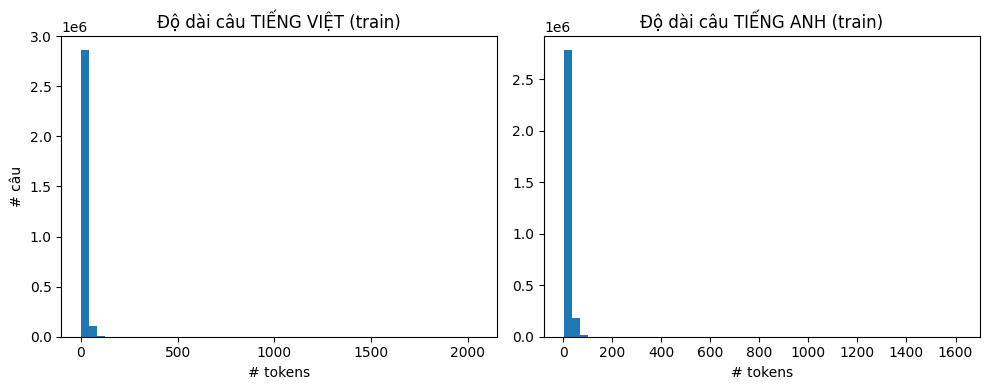

In [7]:
# ==== Cell 7: Thống kê độ dài câu & vẽ histogram (EDA) ====

def lengths(sent_tok):
    return np.array([len(s) for s in sent_tok])

train_vi_len = lengths(train_vi_tok)
train_en_len = lengths(train_en_tok)

print("Độ dài trung bình:")
print("VI train:", train_vi_len.mean(), "tokens")
print("EN train:", train_en_len.mean(), "tokens")

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(train_vi_len, bins=50)
plt.title("Độ dài câu TIẾNG VIỆT (train)")
plt.xlabel("# tokens")
plt.ylabel("# câu")

plt.subplot(1,2,2)
plt.hist(train_en_len, bins=50)
plt.title("Độ dài câu TIẾNG ANH (train)")
plt.xlabel("# tokens")
plt.tight_layout()
plt.show()


In [8]:
# ==== Cell 8: Lọc câu quá ngắn / quá dài trong TRAIN (để train ổn định hơn) ====

def filter_by_length(src_tok, trg_tok, min_len=3, max_len=64):
    new_src, new_trg = [], []
    for s, t in zip(src_tok, trg_tok):
        if min_len <= len(s) <= max_len and min_len <= len(t) <= max_len:
            new_src.append(s)
            new_trg.append(t)
    return new_src, new_trg

train_vi_tok, train_en_tok = filter_by_length(
    train_vi_tok, train_en_tok,
    min_len=MIN_LEN, max_len=MAX_LEN
)

print("Sau khi lọc theo độ dài:")
print("Train VI:", len(train_vi_tok))
print("Train EN:", len(train_en_tok))


Sau khi lọc theo độ dài:
Train VI: 2953209
Train EN: 2953209


# 4. Xây dựng Vocabulary & phân tích coverage

- Xây dựng vocab cho VI/EN từ tập train.
- Giới hạn **top-K từ phổ biến** (`VI_MAX_VOCAB`, `EN_MAX_VOCAB`).
- Phần còn lại map về `<unk>`.
- Phân tích coverage: top-K từ chiếm bao nhiêu phần trăm token.


In [9]:
# ==== Cell 9: Lớp Vocab & hàm coverage ====

class Vocab:
    def __init__(self, freq_thres: int = 2, max_size: int = None):
        self.freq_thres = freq_thres
        self.max_size   = max_size

        self.PAD = "<pad>"
        self.SOS = "<sos>"
        self.EOS = "<eos>"
        self.UNK = "<unk>"

        self.itos = []
        self.stoi = {}
        self._init_special()

    def _init_special(self):
        self.itos = [self.PAD, self.SOS, self.EOS, self.UNK]
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}

        self.pad_idx = self.stoi[self.PAD]
        self.sos_idx = self.stoi[self.SOS]
        self.eos_idx = self.stoi[self.EOS]
        self.unk_idx = self.stoi[self.UNK]

    def build(self, sentences: List[List[str]]):
        freq = Counter()
        for s in sentences:
            freq.update(s)

        items = [(tok, c) for tok, c in freq.items() if c >= self.freq_thres]
        items.sort(key=lambda x: x[1], reverse=True)

        if self.max_size is not None:
            items = items[:self.max_size]

        for tok, _ in items:
            if tok not in self.stoi:
                self.stoi[tok] = len(self.itos)
                self.itos.append(tok)

    def encode(self, tokens: List[str]) -> List[int]:
        return [self.stoi.get(t, self.unk_idx) for t in tokens]


def freq_list(tokenized_sents):
    c = Counter()
    for s in tokenized_sents:
        c.update(s)
    return np.array(sorted(c.values(), reverse=True), dtype=np.int64)

def coverage_at_k(freqs, k):
    k = min(k, len(freqs))
    return freqs[:k].sum() / freqs.sum() * 100.0

vi_freqs = freq_list(train_vi_tok)
en_freqs = freq_list(train_en_tok)

print("Số từ distinct VI:", len(vi_freqs))
print("Số từ distinct EN:", len(en_freqs))

cov_vi = coverage_at_k(vi_freqs, VI_MAX_VOCAB)
cov_en = coverage_at_k(en_freqs, EN_MAX_VOCAB)
print(f"Top {VI_MAX_VOCAB} từ VI cover ≈ {cov_vi:.2f}% token")
print(f"Top {EN_MAX_VOCAB} từ EN cover ≈ {cov_en:.2f}% token")


Số từ distinct VI: 320402
Số từ distinct EN: 300279
Top 20000 từ VI cover ≈ 97.63% token
Top 20000 từ EN cover ≈ 96.61% token


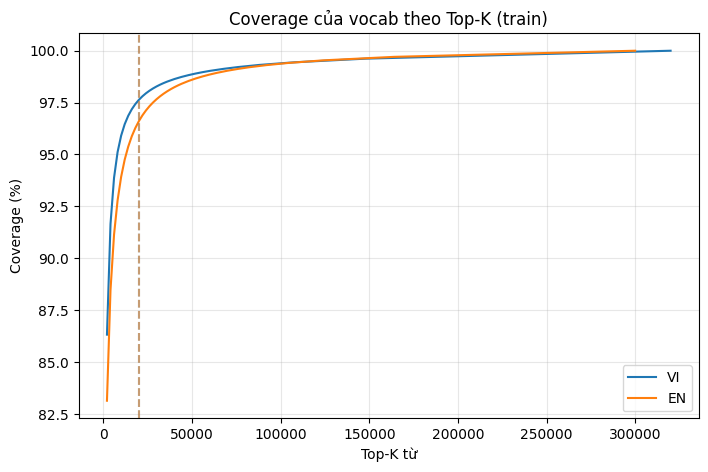

In [10]:
# ==== Cell 10: Vẽ đường cong coverage ====

def coverage_curve(freqs, step=2000):
    total = freqs.sum()
    ks, covs = [], []
    csum = freqs.cumsum()
    for k in range(step, len(freqs)+1, step):
        ks.append(k)
        covs.append(csum[k-1] / total * 100)
    return ks, covs

vi_ks, vi_covs = coverage_curve(vi_freqs)
en_ks, en_covs = coverage_curve(en_freqs)

plt.figure(figsize=(8,5))
plt.plot(vi_ks, vi_covs, label="VI")
plt.plot(en_ks, en_covs, label="EN")
plt.axvline(VI_MAX_VOCAB, color="tab:blue", linestyle="--", alpha=0.5)
plt.axvline(EN_MAX_VOCAB, color="tab:orange", linestyle="--", alpha=0.5)
plt.xlabel("Top-K từ")
plt.ylabel("Coverage (%)")
plt.title("Coverage của vocab theo Top-K (train)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [11]:
# ==== Cell 11: Build vocab ====

vi_vocab = Vocab(freq_thres=2, max_size=VI_MAX_VOCAB)
vi_vocab.build(train_vi_tok)

en_vocab = Vocab(freq_thres=2, max_size=EN_MAX_VOCAB)
en_vocab.build(train_en_tok)

print("Vocab VI:", len(vi_vocab.itos))
print("Vocab EN:", len(en_vocab.itos))


Vocab VI: 20004
Vocab EN: 20004


# 5. Dataset, DataLoader

- Dùng PhoMT:
  - `train` cho training
  - `dev` cho validation
  - `test` cho đánh giá cuối cùng
- Mỗi mẫu:
  - Thêm `<sos>` + `<eos>` ở đầu/cuối.
  - Giới hạn tối đa `MAX_LEN` token.
- Dùng `Collate` để padding theo batch.

In [12]:
# ==== Cell 12: Dataset & Collate ====

class MTDataset(Dataset):
    def __init__(self, src_sents, trg_sents, src_vocab: Vocab, trg_vocab: Vocab, max_len=64):
        self.src_sents = src_sents
        self.trg_sents = trg_sents
        self.src_vocab = src_vocab
        self.trg_vocab = trg_vocab
        self.max_len   = max_len

    def __len__(self):
        return len(self.src_sents)

    def __getitem__(self, idx):
        src_tokens = self.src_sents[idx][: self.max_len - 2]
        trg_tokens = self.trg_sents[idx][: self.max_len - 2]

        src_ids = [self.src_vocab.sos_idx] + self.src_vocab.encode(src_tokens) + [self.src_vocab.eos_idx]
        trg_ids = [self.trg_vocab.sos_idx] + self.trg_vocab.encode(trg_tokens) + [self.trg_vocab.eos_idx]

        return torch.tensor(src_ids), torch.tensor(trg_ids)


class Collate:
    def __init__(self, pad_idx, max_len=64):
        self.pad_idx = pad_idx
        self.max_len = max_len

    def __call__(self, batch):
        src, trg = zip(*batch)
        src = [s[:self.max_len] for s in src]
        trg = [t[:self.max_len] for t in trg]

        src = pad_sequence(src, batch_first=True, padding_value=self.pad_idx)
        trg = pad_sequence(trg, batch_first=True, padding_value=self.pad_idx)
        return src, trg


In [13]:
# ==== Cell 13: Tạo Dataset & (tuỳ chọn) giới hạn số mẫu ====

train_ds = MTDataset(train_vi_tok, train_en_tok, vi_vocab, en_vocab, max_len=MAX_LEN)
val_ds   = MTDataset(dev_vi_tok,   dev_en_tok,   vi_vocab, en_vocab, max_len=MAX_LEN)
test_ds  = MTDataset(test_vi_tok,  test_en_tok,  vi_vocab, en_vocab, max_len=MAX_LEN)

def make_subset(ds, max_samples):
    if max_samples is None or max_samples >= len(ds):
        return ds
    idx = random.sample(range(len(ds)), max_samples)
    return Subset(ds, idx)

train_ds = make_subset(train_ds, MAX_TRAIN_SAMPLES)
val_ds   = make_subset(val_ds,   MAX_VAL_SAMPLES)
test_ds  = make_subset(test_ds,  MAX_TEST_SAMPLES)

print("Train samples:", len(train_ds))
print("Valid samples:", len(val_ds))
print("Test  samples:", len(test_ds))


Train samples: 1000000
Valid samples: 18719
Test  samples: 19151


In [14]:
# ==== Cell 14: DataLoader ====

pad_idx = vi_vocab.pad_idx

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=Collate(pad_idx, max_len=MAX_LEN)
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=Collate(pad_idx, max_len=MAX_LEN)
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=Collate(pad_idx, max_len=MAX_LEN)
)

print("Batches train:", len(train_loader))
print("Batches valid:", len(val_loader))
print("Batches test :", len(test_loader))


Batches train: 3907
Batches valid: 74
Batches test : 75


# 6. Kiến trúc Transformer from scratch

Triển khai từ các thành phần:

- Positional Encoding
- Multi-Head Attention (Scaled Dot-Product)
- Feed-Forward Network (FFN)
- Encoder Layer, Decoder Layer
- Full Transformer Seq2Seq

In [15]:
# ==== Cell 15: Positional Encoding & Embedding ====

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        pe = pe.unsqueeze(0)   # (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        T = x.size(1)
        return x + self.pe[:, :T, :]


class TokenPosEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.pe  = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        self.scale   = math.sqrt(d_model)

    def forward(self, x):
        x = self.emb(x) * self.scale
        x = self.pe(x)
        x = self.dropout(x)
        return x


In [16]:
# ==== Cell 16: Multi-Head Attention, FFN, Encoder & Decoder layers ====

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads

        self.w_q = nn.Linear(d_model, d_model)
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        self.w_o = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)

    def forward(self, q, k, v, mask=None):
        B, Q_len, _ = q.size()

        def split(x):
            return x.view(B, -1, self.n_heads, self.head_dim).transpose(1, 2)

        Q = split(self.w_q(q))
        K = split(self.w_k(k))
        V = split(self.w_v(v))

        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale  # (B,h,Q,K)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, float("-1e9"))

        attn = torch.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        out  = torch.matmul(attn, V)  # (B,h,Q,dim)

        out = out.transpose(1,2).contiguous().view(B, Q_len, self.d_model)
        out = self.w_o(out)
        return out


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff,   d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn       = FeedForward(d_model, d_ff, dropout)
        self.norm1     = nn.LayerNorm(d_model)
        self.norm2     = nn.LayerNorm(d_model)
        self.drop1     = nn.Dropout(dropout)
        self.drop2     = nn.Dropout(dropout)

    def forward(self, x, mask):
        _x = x
        x  = self.self_attn(x, x, x, mask)
        x  = self.drop1(x)
        x  = self.norm1(x + _x)

        _x = x
        x  = self.ffn(x)
        x  = self.drop2(x)
        x  = self.norm2(x + _x)
        return x


class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, dropout, max_len):
        super().__init__()
        self.emb = TokenPosEmbedding(vocab_size, d_model, max_len, dropout)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

    def forward(self, src, src_mask):
        x = self.emb(src)
        for layer in self.layers:
            x = layer(x, src_mask)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn  = MultiHeadAttention(d_model, n_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout)
        self.ffn        = FeedForward(d_model, d_ff, dropout)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)

        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.drop3 = nn.Dropout(dropout)

    def forward(self, x, enc_out, trg_mask, src_mask):
        _x = x
        x  = self.self_attn(x, x, x, trg_mask)
        x  = self.drop1(x)
        x  = self.norm1(x + _x)

        _x = x
        x  = self.cross_attn(x, enc_out, enc_out, src_mask)
        x  = self.drop2(x)
        x  = self.norm2(x + _x)

        _x = x
        x  = self.ffn(x)
        x  = self.drop3(x)
        x  = self.norm3(x + _x)
        return x


class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_layers, n_heads, d_ff, dropout, max_len):
        super().__init__()
        self.emb = TokenPosEmbedding(vocab_size, d_model, max_len, dropout)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, trg, enc_out, trg_mask, src_mask):
        x = self.emb(trg)
        for layer in self.layers:
            x = layer(x, enc_out, trg_mask, src_mask)
        return self.fc_out(x)


In [17]:
# ==== Cell 17: Mask & model wrapper ====

def make_src_mask(src, pad_idx):
    return (src != pad_idx).unsqueeze(1).unsqueeze(2)  # (B,1,1,S)

def make_trg_mask(trg, pad_idx):
    pad_mask = (trg != pad_idx).unsqueeze(1).unsqueeze(2)  # (B,1,1,T)
    T = trg.size(1)
    sub_mask = torch.tril(torch.ones(T, T, device=trg.device)).bool()
    sub_mask = sub_mask.unsqueeze(0).unsqueeze(1)
    return pad_mask & sub_mask


class Transformer(nn.Module):
    def __init__(self,
                 src_vocab_size, trg_vocab_size,
                 src_pad_idx,   trg_pad_idx,
                 d_model, n_layers, n_heads, d_ff,
                 dropout=0.1, max_len=5000):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, n_layers, n_heads, d_ff, dropout, max_len)
        self.decoder = Decoder(trg_vocab_size, d_model, n_layers, n_heads, d_ff, dropout, max_len)
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

    def forward(self, src, trg):
        src_mask = make_src_mask(src, self.src_pad_idx)
        trg_mask = make_trg_mask(trg, self.trg_pad_idx)
        enc_out  = self.encoder(src, src_mask)
        out      = self.decoder(trg, enc_out, trg_mask, src_mask)
        return out


# 7. Huấn luyện mô hình

- Loss: Cross-Entropy với **Label Smoothing**.
- Optimizer: Adam.
- Scheduler: **Noam (warmup)** giống paper Transformer.
- Hỗ trợ **multi-GPU** với `nn.DataParallel`.
- Có **thanh tiến trình tqdm**.

In [18]:
# ==== Cell 18: Khởi tạo model, optimizer, criterion, scheduler ====

SRC_VOCAB = len(vi_vocab.itos)
TRG_VOCAB = len(en_vocab.itos)
SRC_PAD   = vi_vocab.pad_idx
TRG_PAD   = en_vocab.pad_idx

model = Transformer(
    src_vocab_size=SRC_VOCAB,
    trg_vocab_size=TRG_VOCAB,
    src_pad_idx=SRC_PAD,
    trg_pad_idx=TRG_PAD,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_ff=D_FF,
    dropout=DROPOUT,
    max_len=MAX_POS
).to(device)

if NUM_GPU > 1:
    model = nn.DataParallel(model)
    print("Using DataParallel")

optimizer = optim.Adam(model.parameters(), lr=1e-4, betas=(0.9,0.98), eps=1e-9)


class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing, vocab_size, ignore_index=0):
        super().__init__()
        self.smoothing  = smoothing
        self.confidence = 1.0 - smoothing
        self.vocab_size = vocab_size
        self.ignore_idx = ignore_index

    def forward(self, logits, target):
        log_probs = logits.log_softmax(dim=-1)

        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (self.vocab_size - 2))
            mask_pad = target == self.ignore_idx
            t = target.clone()
            t[mask_pad] = 0
            true_dist.scatter_(1, t.unsqueeze(1), self.confidence)
            true_dist[mask_pad] = 0

        loss = torch.sum(-true_dist * log_probs, dim=-1)
        loss = loss[target != self.ignore_idx]
        return loss.mean()


class NoamLR:
    def __init__(self, optimizer, d_model, warmup_steps):
        self.opt = optimizer
        self.d_model = d_model
        self.warmup = warmup_steps
        self.step_num = 0

    def step(self):
        self.step_num += 1
        lr = (self.d_model ** -0.5) * min(
            self.step_num ** -0.5,
            self.step_num * (self.warmup ** -1.5)
        )
        for g in self.opt.param_groups:
            g["lr"] = lr
        return lr

    def zero_grad(self):
        self.opt.zero_grad()

criterion = LabelSmoothingLoss(0.1, TRG_VOCAB, ignore_index=TRG_PAD).to(device)
scheduler = NoamLR(optimizer, d_model=D_MODEL, warmup_steps=WARMUP_STEPS)


Using DataParallel


In [19]:
# ==== Cell 19: train_one_epoch & evaluate ====

def train_one_epoch(model, loader, optimizer, scheduler, criterion,
                    epoch, total_epochs, clip=1.0, max_batches=None):
    model.train()
    total_loss = 0
    total_tokens = 0

    bar = tqdm(loader, desc=f"Train {epoch}/{total_epochs}", leave=False)
    for i, (src, trg) in enumerate(bar):
        if max_batches is not None and i >= max_batches:
            break

        src, trg = src.to(device), trg.to(device)
        trg_in  = trg[:, :-1]
        trg_out = trg[:, 1:]

        optimizer.zero_grad()
        logits = model(src, trg_in)  # (B, T-1, V)
        B, T, V = logits.shape
        logits  = logits.reshape(-1, V)
        trg_out = trg_out.reshape(-1)

        loss = criterion(logits, trg_out)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        scheduler.step()

        non_pad = trg_out != TRG_PAD
        n_tok   = non_pad.sum().item()

        total_loss   += loss.item() * n_tok
        total_tokens += n_tok

        cur_loss = total_loss / max(total_tokens, 1)
        bar.set_postfix(loss=f"{cur_loss:.4f}")

    mean_loss = total_loss / total_tokens
    ppl = math.exp(mean_loss)
    return mean_loss, ppl


@torch.no_grad()
def evaluate(model, loader, criterion, epoch, total_epochs, max_batches=None):
    model.eval()
    total_loss = 0
    total_tokens = 0

    bar = tqdm(loader, desc=f"Valid {epoch}/{total_epochs}", leave=False)
    for i, (src, trg) in enumerate(bar):
        if max_batches is not None and i >= max_batches:
            break

        src, trg = src.to(device), trg.to(device)
        trg_in  = trg[:, :-1]
        trg_out = trg[:, 1:]

        logits = model(src, trg_in)
        B, T, V = logits.shape
        logits  = logits.reshape(-1, V)
        trg_out = trg_out.reshape(-1)

        loss = criterion(logits, trg_out)

        non_pad = trg_out != TRG_PAD
        n_tok   = non_pad.sum().item()

        total_loss   += loss.item() * n_tok
        total_tokens += n_tok

        cur_loss = total_loss / max(total_tokens, 1)
        bar.set_postfix(loss=f"{cur_loss:.4f}")

    mean_loss = total_loss / total_tokens
    ppl = math.exp(mean_loss)
    return mean_loss, ppl


In [20]:
# ==== Cell 20: Vòng lặp huấn luyện chính ====

history = {"train_loss": [], "train_ppl": [],
           "val_loss":   [], "val_ppl":   [],
           "lr": []}

best_val = float("inf")
SAVE_PATH = "transformer_vi_en_phomt.pth"

for epoch in range(1, N_EPOCHS + 1):
    train_loss, train_ppl = train_one_epoch(
        model, train_loader, optimizer, scheduler, criterion,
        epoch, N_EPOCHS
    )

    val_loss, val_ppl = evaluate(
        model, val_loader, criterion,
        epoch, N_EPOCHS
    )

    cur_lr = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(train_loss)
    history["train_ppl"].append(train_ppl)
    history["val_loss"].append(val_loss)
    history["val_ppl"].append(val_ppl)
    history["lr"].append(cur_lr)

    if val_loss < best_val:
        best_val = val_loss
        to_save = model.module if isinstance(model, nn.DataParallel) else model
        torch.save(to_save.state_dict(), SAVE_PATH)

    print(f"[Epoch {epoch}/{N_EPOCHS}] "
          f"Train Loss {train_loss:.4f} | PPL {train_ppl:.2f} || "
          f"Val Loss {val_loss:.4f} | PPL {val_ppl:.2f} || "
          f"LR {cur_lr:.6f}")

print("Best validation loss:", best_val)


Train 1/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 1/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 1/15] Train Loss 5.2976 | PPL 199.86 || Val Loss 4.3876 | PPL 80.45 || LR 0.000965


Train 2/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 2/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 2/15] Train Loss 4.2423 | PPL 69.57 || Val Loss 3.9389 | PPL 51.36 || LR 0.000707


Train 3/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 3/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 3/15] Train Loss 3.9889 | PPL 54.00 || Val Loss 3.7662 | PPL 43.21 || LR 0.000577


Train 4/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 4/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 4/15] Train Loss 3.8660 | PPL 47.75 || Val Loss 3.6668 | PPL 39.13 || LR 0.000500


Train 5/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 5/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 5/15] Train Loss 3.7858 | PPL 44.07 || Val Loss 3.6020 | PPL 36.67 || LR 0.000447


Train 6/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 6/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 6/15] Train Loss 3.7278 | PPL 41.59 || Val Loss 3.5415 | PPL 34.52 || LR 0.000408


Train 7/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 7/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 7/15] Train Loss 3.6823 | PPL 39.74 || Val Loss 3.5101 | PPL 33.45 || LR 0.000378


Train 8/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 8/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 8/15] Train Loss 3.6452 | PPL 38.29 || Val Loss 3.4619 | PPL 31.88 || LR 0.000354


Train 9/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 9/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 9/15] Train Loss 3.6142 | PPL 37.12 || Val Loss 3.4416 | PPL 31.24 || LR 0.000333


Train 10/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 10/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 10/15] Train Loss 3.5878 | PPL 36.15 || Val Loss 3.4193 | PPL 30.55 || LR 0.000316


Train 11/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 11/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 11/15] Train Loss 3.5646 | PPL 35.32 || Val Loss 3.3884 | PPL 29.62 || LR 0.000301


Train 12/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 12/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 12/15] Train Loss 3.5444 | PPL 34.62 || Val Loss 3.3752 | PPL 29.23 || LR 0.000289


Train 13/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 13/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 13/15] Train Loss 3.5262 | PPL 34.00 || Val Loss 3.3545 | PPL 28.63 || LR 0.000277


Train 14/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 14/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 14/15] Train Loss 3.5102 | PPL 33.45 || Val Loss 3.3457 | PPL 28.38 || LR 0.000267


Train 15/15:   0%|          | 0/3907 [00:00<?, ?it/s]

Valid 15/15:   0%|          | 0/74 [00:00<?, ?it/s]

[Epoch 15/15] Train Loss 3.4955 | PPL 32.97 || Val Loss 3.3272 | PPL 27.86 || LR 0.000258
Best validation loss: 3.327173781948202


# 8. Đánh giá: Loss, PPL, BLEU

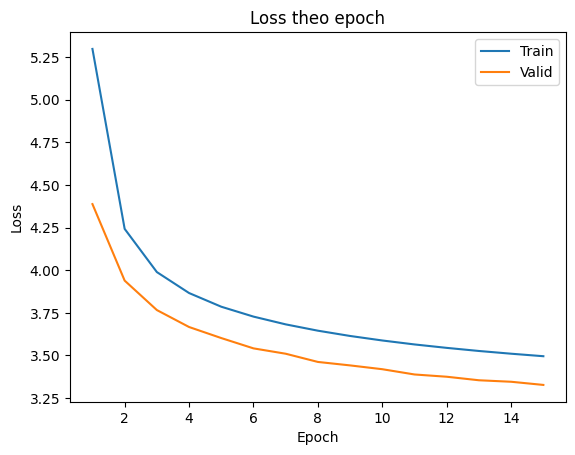

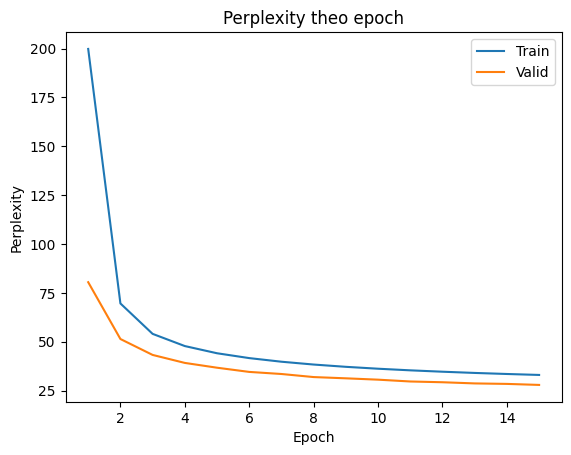

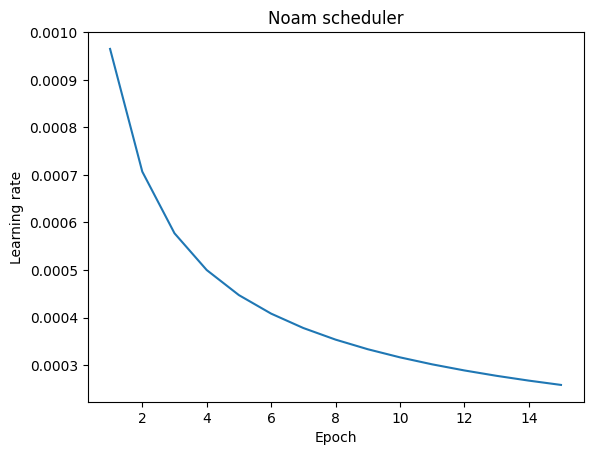

In [21]:
# ==== Cell 21: Vẽ Loss, Perplexity, Learning Rate ====

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="Train")
plt.plot(epochs, history["val_loss"],   label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss theo epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["train_ppl"], label="Train")
plt.plot(epochs, history["val_ppl"],   label="Valid")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity theo epoch")
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning rate")
plt.title("Noam scheduler")
plt.show()


In [22]:
# ==== Cell 22: Hàm dịch (greedy, beam) & BLEU ====

def ids_to_tokens(ids, vocab: Vocab):
    toks = []
    for i in ids:
        if i == vocab.eos_idx:
            break
        if i in (vocab.sos_idx, vocab.pad_idx):
            continue
        toks.append(vocab.itos[i])
    return toks


@torch.no_grad()
def translate_greedy(sent_vi: str, model, src_vocab: Vocab, trg_vocab: Vocab,
                     max_len=64):
    model.eval()
    src_tokens = tokenize_vi(sent_vi)[: max_len - 2]
    src_ids = [src_vocab.sos_idx] + src_vocab.encode(src_tokens) + [src_vocab.eos_idx]
    src = torch.tensor(src_ids).unsqueeze(0).to(device)

    src_mask = make_src_mask(src, src_vocab.pad_idx)
    enc_out  = model.encoder(src, src_mask)

    trg_ids = [trg_vocab.sos_idx]
    for _ in range(max_len):
        trg = torch.tensor(trg_ids).unsqueeze(0).to(device)
        trg_mask = make_trg_mask(trg, trg_vocab.pad_idx)
        out = model.decoder(trg, enc_out, trg_mask, src_mask)
        next_tok = out[:, -1, :].argmax(dim=-1).item()
        trg_ids.append(next_tok)
        if next_tok == trg_vocab.eos_idx:
            break

    return " ".join(ids_to_tokens(trg_ids, trg_vocab))


@torch.no_grad()
def translate_beam(sent_vi: str, model, src_vocab: Vocab, trg_vocab: Vocab,
                   max_len=64, beam_size=5, length_penalty=1.0):
    model.eval()
    src_tokens = tokenize_vi(sent_vi)[: max_len - 2]
    src_ids = [src_vocab.sos_idx] + src_vocab.encode(src_tokens) + [src_vocab.eos_idx]
    src = torch.tensor(src_ids).unsqueeze(0).to(device)

    src_mask = make_src_mask(src, src_vocab.pad_idx)
    enc_out  = model.encoder(src, src_mask)

    beams = [(0.0, [trg_vocab.sos_idx])]
    completed = []

    for _ in range(max_len):
        new_beams = []
        for log_p, seq in beams:
            if seq[-1] == trg_vocab.eos_idx:
                completed.append((log_p, seq))
                continue

            trg = torch.tensor(seq).unsqueeze(0).to(device)
            trg_mask = make_trg_mask(trg, trg_vocab.pad_idx)
            out = model.decoder(trg, enc_out, trg_mask, src_mask)
            log_probs = out[:, -1, :].log_softmax(dim=-1).squeeze(0)

            topk_logp, topk_idx = torch.topk(log_probs, beam_size)
            for lp, idx in zip(topk_logp, topk_idx):
                new_seq = seq + [idx.item()]
                new_beams.append((log_p + lp.item(), new_seq))

        beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_size]
        if len(completed) >= beam_size:
            break

    if not completed:
        completed = beams

    def score(item):
        log_p, seq = item
        L = len(seq)
        return log_p / (L ** length_penalty)

    best = max(completed, key=score)[1]
    return " ".join(ids_to_tokens(best, trg_vocab))


@torch.no_grad()
def bleu_on_test(model, src_sents, ref_sents,
                 src_vocab: Vocab, trg_vocab: Vocab,
                 max_len=64, beam_size=5):
    preds, refs = [], []
    for s_vi, s_en in tqdm(zip(src_sents, ref_sents),
                           total=len(src_sents),
                           desc="BLEU", leave=False):
        pred = translate_beam(s_vi, model, src_vocab, trg_vocab,
                              max_len=max_len, beam_size=beam_size)
        preds.append(pred)
        refs.append(s_en)
    bleu = sacrebleu.corpus_bleu(preds, [refs])
    return bleu, preds


In [23]:
# ==== Cell 23: Load best model, dịch thử, tính BLEU (giới hạn N câu) ====

import torch

print("Đang load best model...")

# Load state_dict vào CPU trước cho nhanh
state = torch.load(SAVE_PATH, map_location="cpu")

# Khởi tạo lại mô hình
best_model = Transformer(
    src_vocab_size=SRC_VOCAB,
    trg_vocab_size=TRG_VOCAB,
    src_pad_idx=SRC_PAD,
    trg_pad_idx=TRG_PAD,
    d_model=D_MODEL,
    n_layers=N_LAYERS,
    n_heads=N_HEADS,
    d_ff=D_FF,
    dropout=DROPOUT,
    max_len=MAX_POS
)

# Load weight
best_model.load_state_dict(state)

# Chuyển sang GPU sau cùng (tối ưu tốc độ)
best_model = best_model.to(device).eval()

print("✔ Model load xong!")

# -------------------------------------------
# Dịch thử 5 câu
# -------------------------------------------

print("\nDịch thử 5 câu từ tập test:")
for i in range(5):
    print("=" * 50)
    print("SRC:", test_vi_raw[i])
    print("REF:", test_en_raw[i])
    print("GREEDY:", translate_greedy(test_vi_raw[i], best_model, vi_vocab, en_vocab))
    print("BEAM  :", translate_beam(test_vi_raw[i], best_model, vi_vocab, en_vocab, beam_size=5))

# -------------------------------------------
# Giới hạn số câu tính BLEU
# -------------------------------------------

TEST_LIMIT = 500   # chỉnh số này (None = dùng full test, nhưng rất chậm!)

if TEST_LIMIT is None:
    src_eval = test_vi_raw
    ref_eval = test_en_raw
    print(f"\nTính BLEU trên toàn bộ {len(test_vi_raw)} câu test.")
else:
    n_eval = min(TEST_LIMIT, len(test_vi_raw))
    src_eval = test_vi_raw[:n_eval]
    ref_eval = test_en_raw[:n_eval]
    print(f"\nTính BLEU trên {n_eval}/{len(test_vi_raw)} câu test...")

# -------------------------------------------
# Tính BLEU
# -------------------------------------------

bleu, preds_for_eval = bleu_on_test(
    best_model,
    src_eval,
    ref_eval,
    vi_vocab,
    en_vocab,
    max_len=MAX_LEN,
    beam_size=5
)

print("\n🎯 Test BLEU (beam search):", bleu.score)


Đang load best model...
✔ Model load xong!

Dịch thử 5 câu từ tập test:
SRC: Anh Albert Barnett và chị Susan Barnett, thuộc hội thánh West ở Tuscaloosa, Alabama
REF: Brother Albert Barnett and his wife, Sister Susan Barnett, from the West Congregation in Tuscaloosa, Alabama
GREEDY: he was a <unk> and <unk> , the st . susan <unk> in alabama , west indies .
BEAM  : mr . <unk> and susan <unk> , the saint <unk> society in alabama , west indies .
SRC: Ngày 11 và 12-1-2020, những cơn bão lớn đã quét qua và phá huỷ nhiều vùng ở miền nam và miền trung Hoa Kỳ.
REF: Severe storms ripped through parts of the southern and midwestern United States on January 11 and 12, 2020.
GREEDY: on 12 november 2020 , the storm - - 1 , the vast majority of the storm had destroyed and destroyed many central and central america .
BEAM  : on november 12 , 2020 , the storm destroyed large areas of the south and central united states in central and central america .
SRC: Những trận mưa to và gió lớn trong suốt hai ng

BLEU:   0%|          | 0/500 [00:00<?, ?it/s]

That's 100 lines that end in a tokenized period ('.')
It looks like you forgot to detokenize your test data, which may hurt your score.
If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.



🎯 Test BLEU (beam search): 9.10523590543694


# 9. Xuất kết quả & Gemini Score

In [25]:
import pandas as pd

# Lấy số câu đã dùng trong BLEU
n_eval = len(preds_for_eval)

df_eval = pd.DataFrame({
    "src_vi": src_eval[:n_eval],
    "ref_en": ref_eval[:n_eval],
    "pred_en": preds_for_eval
})

csv_path = "phomt_vi_en_predictions_for_gemini.csv"
df_eval.to_csv(csv_path, index=False, encoding="utf-8")

print("Đã lưu:", csv_path)
print(f"Số mẫu ghi vào CSV: {n_eval}")

Đã lưu: phomt_vi_en_predictions_for_gemini.csv
Số mẫu ghi vào CSV: 500


In [33]:
# ==== Gemini Score (batch scoring, dùng Kaggle Secrets + flash-latest) ====
!pip install -q google-generativeai

import json, re
import numpy as np
from tqdm.auto import tqdm
import google.generativeai as genai
from kaggle_secrets import UserSecretsClient

# --- Lấy API từ Kaggle Secrets ---
user_secrets = UserSecretsClient()
API_KEY = user_secrets.get_secret("GEMINI_API_KEY")  # tên secret bạn đã tạo

if not API_KEY:
    raise ValueError("❌ Không lấy được GEMINI_API_KEY từ Kaggle Secrets.")

genai.configure(api_key=API_KEY)

MODEL_ID = "gemini-flash-latest"
gemini_model = genai.GenerativeModel(MODEL_ID)
print("✔ Gemini model ready:", MODEL_ID)

# --- Dữ liệu để chấm: ưu tiên src_eval/ref_eval từ bước BLEU ---
src_list = src_eval if "src_eval" in globals() else test_vi_raw
ref_list = ref_eval if "ref_eval" in globals() else test_en_raw

n_available = min(len(src_list), len(ref_list), len(preds_for_eval))

# Giới hạn số câu chấm để tiết kiệm quota
MAX_GEMINI_SAMPLES = 100   # bạn có thể tăng lên 100, nhưng cẩn thận quota
n = n_available if MAX_GEMINI_SAMPLES is None else min(MAX_GEMINI_SAMPLES, n_available)

BATCH_SIZE = 10          # số câu mỗi batch (1 request)

print(f"Sẽ chấm {n}/{n_available} câu bằng Gemini, {BATCH_SIZE} câu / 1 request.")

all_scores = []

for start in tqdm(range(0, n, BATCH_SIZE), desc="Gemini batch scoring"):
    end = min(start + BATCH_SIZE, n)
    batch_indices = list(range(start, end))

    # Tạo prompt batch
    items_text = []
    for local_i, idx in enumerate(batch_indices, start=1):
        src = src_list[idx]
        ref = ref_list[idx]
        pred = preds_for_eval[idx]
        items_text.append(
            f"""Item {local_i}:
Source (Vietnamese):
{src}

Reference (English):
{ref}

Candidate (English):
{pred}
"""
        )

    batch_prompt = f"""
You are evaluating a batch of Vietnamese → English translations.

For each item below, compare the candidate translation with the reference
in terms of meaning preservation, fluency, and grammatical correctness.

For EACH item, give a score between 0 and 1 (0 = completely wrong, 1 = perfect).

Return the scores ONLY as a JSON array of numbers in order, e.g.:
[0.82, 0.45, 0.97]

Do not add any extra text.

{"".join(items_text)}
"""

    resp = gemini_model.generate_content(batch_prompt)
    text = resp.text.strip()

    # Cố gắng parse JSON
    try:
        batch_scores = json.loads(text)
    except Exception:
        # fallback: lấy tất cả số trong response
        nums = re.findall(r"(\d+(\.\d+)?)", text)
        batch_scores = [float(x[0]) for x in nums]

    # Đảm bảo độ dài khớp số câu trong batch
    if len(batch_scores) < len(batch_indices):
        # nếu thiếu, pad thêm 0.0 cho chắc
        batch_scores += [0.0] * (len(batch_indices) - len(batch_scores))
    batch_scores = batch_scores[:len(batch_indices)]

    # Clamp về [0, 1]
    batch_scores = [max(0.0, min(1.0, float(s))) for s in batch_scores]

    all_scores.extend(batch_scores)

all_scores = np.array(all_scores, dtype=float)
gemini_avg = float(all_scores.mean())

print("\n===== GEMINI SCORE (batch) =====")
print(f"Số câu đã chấm: {len(all_scores)}")
print("Gemini Score (0–1):   ", gemini_avg)
print("Gemini Score (0–100): ", gemini_avg * 100)


✔ Gemini model ready: gemini-flash-latest
Sẽ chấm 100/500 câu bằng Gemini, 10 câu / 1 request.


Gemini batch scoring:   0%|          | 0/10 [00:00<?, ?it/s]


===== GEMINI SCORE (batch) =====
Số câu đã chấm: 100
Gemini Score (0–1):    0.35950000000000004
Gemini Score (0–100):  35.95


In [ ]:
# 